In [1]:
import os
import numpy as np
import pandas as pd
import cv2
import splitfolders
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import shutil
import tensorflow_ranking as tfr
from sklearn.metrics import average_precision_score
from tensorflow.python.client import device_lib
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.python.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout, Conv2D, Add, GlobalAveragePooling2D, ZeroPadding2D
from tensorflow.keras.layers import Activation, Input, MaxPool2D, concatenate
from tensorflow.keras.layers import Reshape, Lambda, Flatten, BatchNormalization, LeakyReLU
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import models
from tensorflow.keras.optimizers import Adam as Adam
from tensorflow.keras.metrics import MeanIoU, AUC, Precision, Recall
from tensorflow_ranking.python.keras.metrics import MeanAveragePrecisionMetric
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import initializers
from tensorflow.keras.models import load_model

2022-08-27 20:06:53.411113: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
physical_devices = tf.config.list_physical_devices('GPU')

2022-08-27 20:07:01.247648: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-08-27 20:07:01.248377: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-08-27 20:07:01.287116: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-27 20:07:01.287422: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-08-27 20:07:01.287438: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-08-27 20:07:01.333808: I tensorflow/stream_executor/platfor

In [3]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

2022-08-27 20:07:01.542729: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-27 20:07:01.543076: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-08-27 20:07:01.543281: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-27 20:07:01.543898: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573

In [4]:
# input_data_path =r'C:/Users/conm/Desktop/Stenosis-Project/Stenosis detection/input'

train_path = '/home/lunet/conm/Desktop/Stenosis-Project/output/train/stenosis'

# train_path1 = r'C:\Users\conm\Desktop\Stenosis-Project\train_images'

test_path = '/home/lunet/conm/Desktop/Stenosis-Project/test_images'

val_path = '/home/lunet/conm/Desktop/Stenosis-Project/output/val/stenosis'

train_path2 = '/home/lunet/conm/Desktop/Stenosis-Project/output2/train/stenosis'

val_path2 = '/home/lunet/conm/Desktop/Stenosis-Project/output2/val/stenosis'

# train_path2 = r'C:\Users\conm\Desktop\Stenosis-Project\Dataset_Reduced\train\images'

In [5]:
train_labels_csv = pd.read_csv('train_labels.csv')
train_labels_csv_3 = pd.read_csv('train_labels_3.csv')
len(train_labels_csv_3)

5993

In [6]:
test_labels_csv = pd.read_csv('test_labels.csv')

In [7]:
val_labels_csv = pd.read_csv('val_labels.csv')
val_labels_csv_2 = pd.read_csv('val_labels_2.csv')

In [8]:
train_images = []
train_targets = []

val_images = []
val_targets = []

test_images = []
test_targets = []

In [9]:
# Train images to read and resize
# Train labels rescale according to the same size of the train images
for index, row in train_labels_csv_3.iterrows():
    (filename, width, height, class_name, xmin, ymin, xmax, ymax) = row

    pic = cv2.imread(os.path.join(train_path2,filename))
    
    x = pic.shape[0]
    y = pic.shape[1]

    img_Target_size = 224
    x_scale = img_Target_size / x
    y_scale = img_Target_size / y


    pic = cv2.resize(pic, (img_Target_size, img_Target_size))

    pic = pic / 255.0

    # xmin = float(round(xmin * 224))
    # ymin = float(round(ymin * 224))
    # xmax = float(round(xmax * 224))
    # ymax = float(round(ymax * 224))
    x1 = float(np.round(xmin * x_scale))
    y1 = float(np.round(ymin * y_scale))
    x2 = float(np.round(xmax * x_scale))
    y2 = float(np.round(ymax * y_scale))


    # x1 /= img_Target_size
    # y1 /= img_Target_size
    # x2 /= img_Target_size
    # y2 /= img_Target_size
    
    train_images.append(pic)
    train_targets.append((x1, y1, x2, y2))

In [28]:
tf.__version__

'2.4.1'

In [30]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

2022-08-27 21:03:08.759799: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-08-27 21:03:08.759944: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-27 21:03:08.760189: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-08-27 21:03:08.760227: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-08-27 21:03:08.760253: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-08-27 21:03:08.760265: I tensorflow/stream_executor/plat

In [10]:
# Validation images to read and resize
# Validation labels rescale according to the same size of the validation images
for index, row in val_labels_csv_2.iterrows():
    (filename, width, height, class_name, xmin, ymin, xmax, ymax) = row

    pic = cv2.imread(os.path.join(val_path2,filename))
    
    x = pic.shape[0]
    y = pic.shape[1]
    
    img_Target_size = 224
    x_scale = img_Target_size / x
    y_scale = img_Target_size / y

    pic = cv2.resize(pic, (img_Target_size, img_Target_size))

    pic = pic / 255.0

    x1 = float(np.round(xmin * x_scale))
    y1 = float(np.round(ymin * y_scale))
    x2 = float(np.round(xmax * x_scale))
    y2 = float(np.round(ymax * y_scale))
    # xmin = xmin / img_Target_size
    # ymin = ymin / img_Target_size
    # xmax = xmax / img_Target_size
    # ymax = ymax / img_Target_size
    # print(x, y, xmax, ymax)

    val_images.append(pic)
    val_targets.append((x1, y1, x2, y2))

In [11]:
# Test images to read and resize
# Test labels rescale according to the same size of the test images
for index, row in test_labels_csv.iterrows():
    (filename, width, height, class_name, xmin, ymin, xmax, ymax) = row

    pic = cv2.imread(os.path.join(test_path,filename))

    x = pic.shape[0]
    y = pic.shape[1]
    
    img_Target_size = 224
    x_scale = img_Target_size / x
    y_scale = img_Target_size / y

    pic = cv2.resize(pic, (img_Target_size, img_Target_size))
    
    pic = pic / 255.0

    x1 = float(np.round(xmin * x_scale))
    y1 = float(np.round(ymin * y_scale))
    x2 = float(np.round(xmax * x_scale))
    y2 = float(np.round(ymax * y_scale))


    # xmin = xmin / img_Target_size
    # ymin = ymin / img_Target_size
    # xmax = xmax / img_Target_size
    # ymax = ymax / img_Target_size
    
    # print(x, y, xmax, ymax)

    test_images.append(pic)
    test_targets.append((x1, y1, x2, y2))

In [12]:
train_images = np.array(train_images).astype('float32')
train_targets = np.array(train_targets).astype('float32')

In [13]:
val_images = np.array(val_images).astype('float32')
val_targets = np.array(val_targets).astype('float32')

In [14]:
test_images = np.array(test_images).astype('float32')
test_targets = np.array(test_targets).astype('float32')

In [15]:
train_targets

array([[ 98.,  76., 105.,  82.],
       [ 94.,  73., 103.,  81.],
       [ 95.,  72., 103.,  78.],
       ...,
       [ 65.,  79.,  74.,  93.],
       [ 63.,  71.,  71.,  87.],
       [ 65.,  70.,  72.,  87.]], dtype=float32)

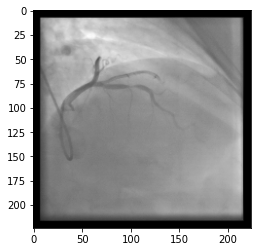

In [16]:
plt.imshow(train_images[0].astype('float32'))
plt.show()

/tmp/ipykernel_20328/4120876742.py:1: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  image = cv2.rectangle(train_images[1], (train_targets[1][0],train_targets[1][1]), (train_targets[1][2],train_targets[1][3]), color=(0,255,0))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


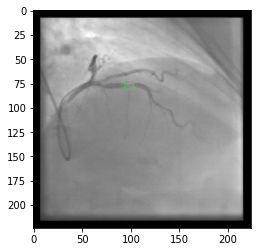

In [17]:
image = cv2.rectangle(train_images[1], (train_targets[1][0],train_targets[1][1]), (train_targets[1][2],train_targets[1][3]), color=(0,255,0))
plt.imshow((image))

In [18]:
# # Calculate average precision
# def calculate_ap(actual, predicted):
#     actual = np.array(actual)
#     predicted = np.array(predicted)

#    #  actual = K.constant(actual)
#    #  predicted = K.constant(predicted)

#     true_positives = np.sum(np.round(actual[:, 0]) * np.round(predicted[:, 0]))
#     false_positives = np.sum(np.round(actual[:, 0]) * np.round(predicted[:, 1]))
#     false_negatives = np.sum(np.round(actual[:, 1]) * np.round(predicted[:, 0]))

#     precision = true_positives / (true_positives + false_positives)
#     recall = true_positives / (true_positives + false_negatives)

#     return (precision, recall)
    
# def perf_measure(y_actual, y_hat):
#     TP = 0
#     FP = 0
#     TN = 0
#     FN = 0

#     for i in range(len(y_hat)): 
#         if y_actual[i]==y_hat[i]==1:
#            TP += 1
#         if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
#            FP += 1
#         if y_actual[i]==y_hat[i]==0:
#            TN += 1
#         if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
#            FN += 1

#     return(TP, FP, TN, FN)

# # def mean_average_precision():


In [19]:
train_targets.shape

(5993, 4)

In [19]:
dataGenerator = ImageDataGenerator()

In [21]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

In [22]:
visible = Input(shape=(224, 224, 3))

x = Conv2D(64, 3, padding='same', name='conv_1')(visible)
x = LeakyReLU(alpha=0.1)(x)
# x = RandomFlip(mode='horizontal', seed=None)(x)
x = BatchNormalization()(x)
block_1 = MaxPool2D(3)(x)

x = Conv2D(64, (3, 3), padding='same', name='conv_2')(block_1)
x = LeakyReLU(alpha=0.1)(x)
x = BatchNormalization()(x)
block_2 = Add()([x, block_1])

x = Conv2D(64, (3, 3), padding='same', name='conv_3')(block_2)
x = LeakyReLU(alpha=0.1)(x)
x = BatchNormalization()(x)
# x = MaxPool2D(pool_size=(2, 2), padding='same')(x)
block_3 = Add()([x, block_2])

x = Conv2D(64, (3, 3), padding='same', name='conv_4')(block_3)
x = LeakyReLU(alpha=0.1)(x)
x = BatchNormalization()(x)
# x = MaxPool2D(pool_size=(2, 2), padding='same')(x)
block_4 = Add()([x, block_3])

x = Conv2D(64, (3, 3), padding='same', name='conv_5')(block_4)
x = LeakyReLU(alpha=0.1)(x)
x = BatchNormalization()(x)
# x = MaxPool2D(pool_size=(2, 2), padding='same')(x)
block_5 = Add()([x, block_4])

x = Conv2D(64, (3, 3), padding='same', name='conv_6')(block_5)
x = LeakyReLU(alpha=0.1)(x)
x = BatchNormalization()(x)
# x = MaxPool2D(pool_size=(2, 2), padding='same')(x)
block_6 = Add()([x, block_5])

x = Conv2D(64, (3, 3), padding='same', name='conv_7')(block_6)
x = LeakyReLU(alpha=0.1)(x)
x = BatchNormalization()(x)
# x = MaxPool2D(pool_size=(2, 2), padding='same')(x)
block_7 = Add()([x, block_6])

x = Conv2D(64, (3, 3), padding='same', name='conv_8')(block_7)
x = LeakyReLU(alpha=0.1)(x)
x = BatchNormalization()(x)
# x = MaxPool2D(pool_size=(2, 2), padding='same')(x)
block_8 = Add()([x, block_7])

x = Conv2D(64, (3, 3), padding='same', name='conv_9')(block_8)
x = LeakyReLU(alpha=0.1)(x)
x = BatchNormalization()(x)
# x = MaxPool2D(pool_size=(2, 2), padding='same')(x)
block_9 = Add()([x, block_8])

x = Conv2D(64, (3, 3), padding='same', name='conv_10')(block_9)
x = LeakyReLU(alpha=0.1)(x)
x = BatchNormalization()(x)
# x = MaxPool2D(pool_size=(2, 2), padding='same')(x)
block_10 = Add()([x, block_9])

x = Conv2D(64, (3, 3), padding='same', name='conv_11')(block_10)
x = LeakyReLU(alpha=0.1)(x)
x = BatchNormalization()(x)
# x = MaxPool2D(pool_size=(2, 2), padding='same')(x)
block_11 = Add()([x, block_10])

x = Conv2D(64, (3, 3), padding='same', name='conv_12')(block_11)
x = LeakyReLU(alpha=0.1)(x)
x = BatchNormalization()(x)
# x = MaxPool2D(pool_size=(2, 2), padding='same')(x)
block_12 = Add()([x, block_11])

x = Conv2D(64, (3, 3), padding='same', name='conv_13')(block_12)
x = LeakyReLU(alpha=0.1)(x)
x = BatchNormalization()(x)
# x = MaxPool2D(pool_size=(2, 2), padding='same')(x)
block_13 = Add()([x, block_12])

x = Conv2D(64, (3, 3), padding='same', name='conv_14')(block_13)
x = LeakyReLU(alpha=0.1)(x)
x = BatchNormalization()(x)
# x = MaxPool2D(pool_size=(2, 2), padding='same')(x)
block_14 = Add()([x, block_13])

glob_layer = GlobalAveragePooling2D()(block_14)
# flat_layer = Flatten()(block_14)
x = Dropout(0.35)(glob_layer)
x = Dense(256, kernel_regularizer=regularizers.l2(0.1))(x)
x = LeakyReLU(alpha=0.1)(x)
x = Dropout(0.35)(x)

outputs = Dense(4)(x)

model = Model(visible, outputs, name='Functional_Model')

# model.summary()

2022-08-27 20:10:58.761328: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-08-27 20:10:58.761705: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-27 20:10:58.762807: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-08-27 20:10:58.762892: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-08-27 20:10:58.762958: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-08-27 20:10:58.763011: I tensorflow/stream_executor/plat

In [23]:
# def average_precision(y_true, y_pred):
#     true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
#     predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
#     precision = true_positives / (predicted_positives + K.epsilon())
#     return precision

In [24]:
# def get_iou(ground_truth, pred):
#     # coordinates of the area of intersection.
#     ix1 = np.maximum(ground_truth[0], pred[0])
#     iy1 = np.maximum(ground_truth[1], pred[1])
#     ix2 = np.minimum(ground_truth[2], pred[2])
#     iy2 = np.minimum(ground_truth[3], pred[3])
    
#     # Intersection height and width.
#     i_height = np.maximum(iy2 - iy1 + 1, np.array(0.))
#     i_width = np.maximum(ix2 - ix1 + 1, np.array(0.))
    
#     area_of_intersection = i_height * i_width
    
#     # Ground Truth dimensions.
#     gt_height = ground_truth[3] - ground_truth[1] + 1
#     gt_width = ground_truth[2] - ground_truth[0] + 1
    
#     # Prediction dimensions.
#     pd_height = pred[3] - pred[1] + 1
#     pd_width = pred[2] - pred[0] + 1
    
#     area_of_union = gt_height * gt_width + pd_height * pd_width - area_of_intersection
    
#     iou = area_of_intersection / area_of_union
    
#     return iou

In [25]:
# Use mean average precision function in compile model
model.compile(loss='mse', optimizer='adam', metrics=[tf.keras.metrics.Precision()])
# mean_squared_logarithmic_error

In [26]:
dataGenerator.flow(train_images, train_targets, batch_size=64)

In [27]:
keras.backend.clear_session()
np.random.seed(15)
tf.random.set_seed(15)

model_history = model.fit(dataGenerator.flow(train_images, train_targets, batch_size=32),
                            validation_data=(val_images, val_targets),
                            epochs=250, callbacks=[es], verbose=1, shuffle=True)

2022-08-27 20:11:05.496554: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-08-27 20:11:05.527200: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3000000000 Hz


Epoch 1/250


2022-08-27 20:11:07.005927: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-08-27 20:11:08.407467: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2022-08-27 20:11:12.959278: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2022-08-27 20:11:13.156147: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


InvalidArgumentError: 2 root error(s) found.
  (0) Invalid argument:  assertion failed: [predictions must be >= 0] [Condition x >= y did not hold element-wise:] [x (Functional_Model/dense_1/BiasAdd:0) = ] [[0.153490633 0.277255327 -0.435273707...]...] [y (Cast_2/x:0) = ] [0]
	 [[{{node assert_greater_equal/Assert/AssertGuard/else/_1/assert_greater_equal/Assert/AssertGuard/Assert}}]]
	 [[assert_greater_equal/Assert/AssertGuard/branch_executed/_9/_69]]
  (1) Invalid argument:  assertion failed: [predictions must be >= 0] [Condition x >= y did not hold element-wise:] [x (Functional_Model/dense_1/BiasAdd:0) = ] [[0.153490633 0.277255327 -0.435273707...]...] [y (Cast_2/x:0) = ] [0]
	 [[{{node assert_greater_equal/Assert/AssertGuard/else/_1/assert_greater_equal/Assert/AssertGuard/Assert}}]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_4081]

Function call stack:
train_function -> train_function


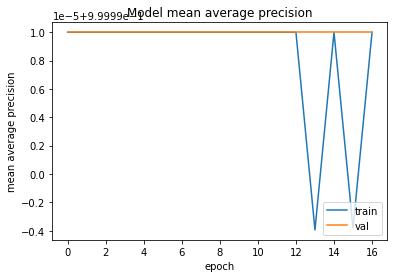

In [ ]:
plt.plot(model_history.history['mean_average_precision_metric'])
plt.plot(model_history.history['val_mean_average_precision_metric'])
plt.title('Model mean average precision')
plt.ylabel('mean average precision')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

In [ ]:
model.save('dummy.h5')
model_load = load_model('dummy.h5')

18063 23143 20572 24962
10411 10035 12669 12669
28913 21136 30858 23770
12544 13328 18522 15484
20258 11101 22014 14425


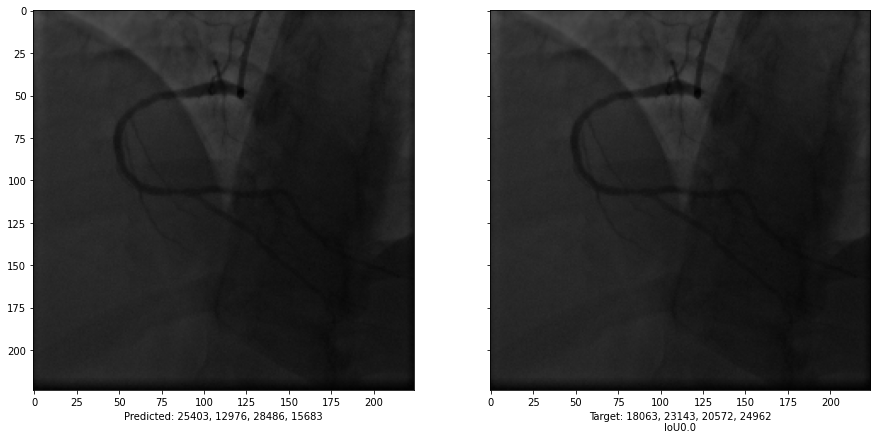

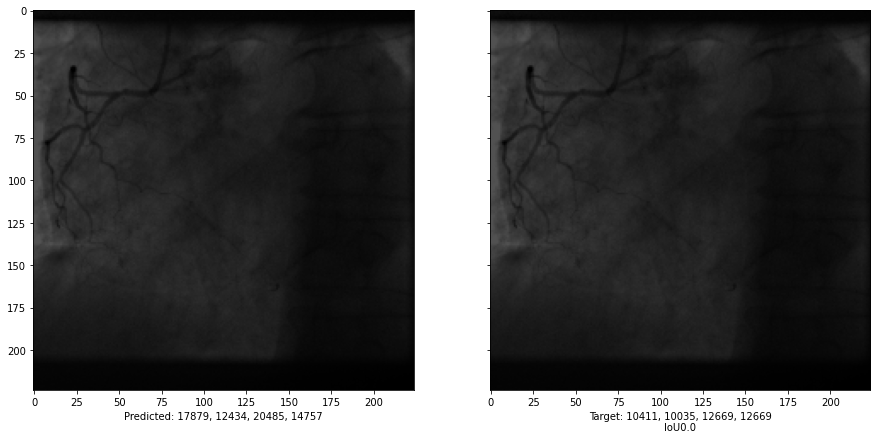

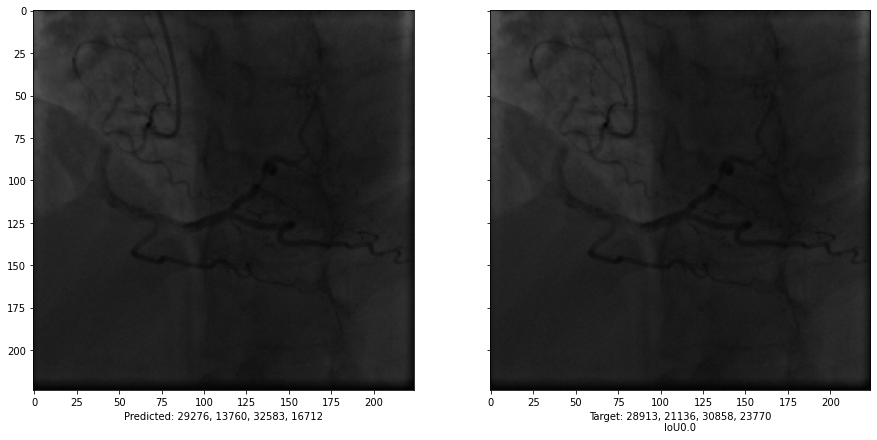

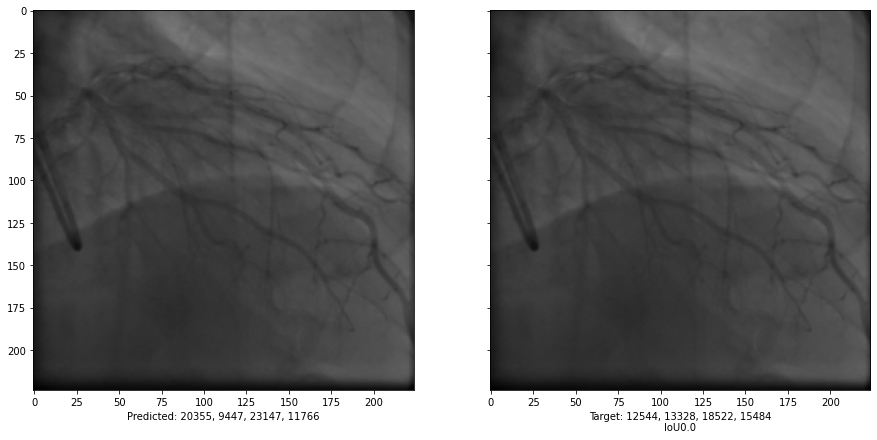

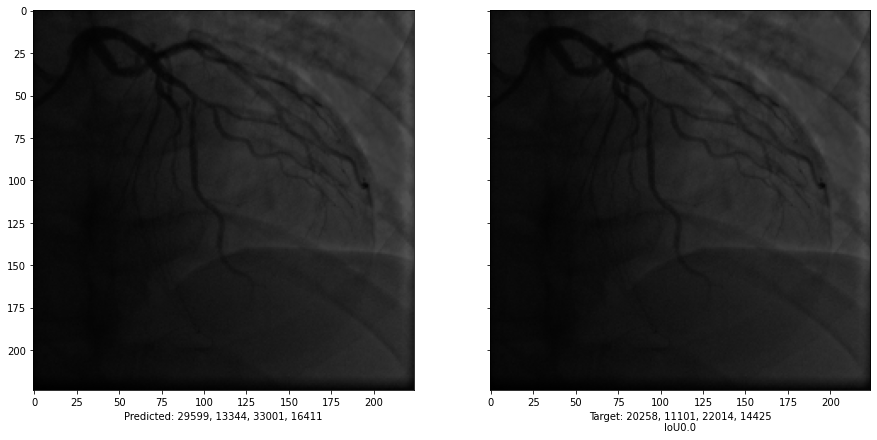

In [ ]:
# To calculate IoU (intersection over union, given two bounding boxes)
# To calculate IoU (intersection over union, given two bounding boxes)
def bounding_box_intersection_over_union(box_predicted, box_truth):
    # get (x, y) coordinates of intersection of bounding boxes
    top_x_intersect = max(box_predicted[0], box_truth[0])
    top_y_intersect = max(box_predicted[1], box_truth[1])
    bottom_x_intersect = min(box_predicted[2], box_truth[2])
    bottom_y_intersect = min(box_predicted[3], box_truth[3])

    # calculate area of the intersection bb (bounding box)
    intersection_area = max(0, bottom_x_intersect - top_x_intersect + 1) * max(
        0, bottom_y_intersect - top_y_intersect + 1
    )

    # calculate area of the prediction bb and ground-truth bb
    box_predicted_area = (box_predicted[2] - box_predicted[0] + 1) * (
        box_predicted[3] - box_predicted[1] + 1
    )
    box_truth_area = (box_truth[2] - box_truth[0] + 1) * (
        box_truth[3] - box_truth[1] + 1
    )

    # calculate intersection over union by taking intersection
    # area and dividing it by the sum of predicted bb and ground truth
    # bb areas subtracted by  the interesection area

    # return ioU
    return intersection_area / float (
        box_predicted_area + box_truth_area - intersection_area
    )


i, mean_iou = 0, 0

# Compare results for 10 images in the test set
for input_image in test_images[:5]:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15), sharey=True, sharex=True)
    im = input_image
    
    # plt.margins(x=0, y=0)

    # Display the image
    ax1.imshow(im)
    ax2.imshow(im)

    input_image = cv2.resize(
        input_image, (224, 224)
    )
    input_image = np.expand_dims(input_image, axis=0)
    preds = model_load.predict(input_image)[0]

    (h, w) = (im).shape[0:2]

    top_left_x, top_left_y = int(preds[0] * w), int(preds[1] * h)

    bottom_right_x, bottom_right_y = int(preds[2] * w), int(preds[3] * h)

    box_predicted = [top_left_x, top_left_y, bottom_right_x, bottom_right_y]
    # Create the bounding box
    rect = patches.Rectangle(
        (top_left_x, top_left_y),
        bottom_right_x - top_left_x,
        bottom_right_y - top_left_y,
        facecolor="none",
        edgecolor="red",
        linewidth=1,
    )
    # Add the bounding box to the image
    ax1.add_patch(rect)
    ax1.set_xlabel(
        "Predicted: "
        + str(top_left_x)
        + ", "
        + str(top_left_y)
        + ", "
        + str(bottom_right_x)
        + ", "
        + str(bottom_right_y)
    )

    top_left_x, top_left_y = int(test_targets[i][0] * w), int(test_targets[i][1] * h)

    bottom_right_x, bottom_right_y = int(test_targets[i][2] * w), int(test_targets[i][3] * h)

    box_truth = top_left_x, top_left_y, bottom_right_x, bottom_right_y

    mean_iou += bounding_box_intersection_over_union(box_predicted, box_truth)
    # Create the bounding box
    rect = patches.Rectangle(
        (top_left_x, top_left_y),
        bottom_right_x - top_left_x,
        bottom_right_y - top_left_y,
        facecolor="none",
        edgecolor="red",
        linewidth=1,
    )
    # Add the bounding box to the image
    ax2.add_patch(rect)
    # print(top_left_x, top_left_y, bottom_right_x,bottom_right_y)
    ax2.set_xlabel(
        "Target: "
        + str(top_left_x)
        + ", "
        + str(top_left_y)
        + ", "
        + str(bottom_right_x)
        + ", "
        + str(bottom_right_y)
        + "\n"
        + "IoU"
        + str(bounding_box_intersection_over_union(box_predicted, box_truth))
    )
    print(top_left_x, top_left_y, bottom_right_x,bottom_right_y)
    # type(top_left_x)
    i = i + 1
plt.show()